In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

# Load relevant datasets here

In [2]:
raw_signals = pq.read_pandas('../data/train.parquet', columns=[str(i) for i in np.arange(0,900,1)]).to_pandas().values.T

In [16]:
pp_signals = np.load('../preprocessed_data/pp_demo_db2.npy')

In [8]:
# Load metadata as well
meta_train, meta_test = pd.read_csv('../data/metadata_train.csv'), pd.read_csv('../data/metadata_test.csv')

# Plot them here

**Vanilla visualization 1**

<Figure size 432x288 with 0 Axes>

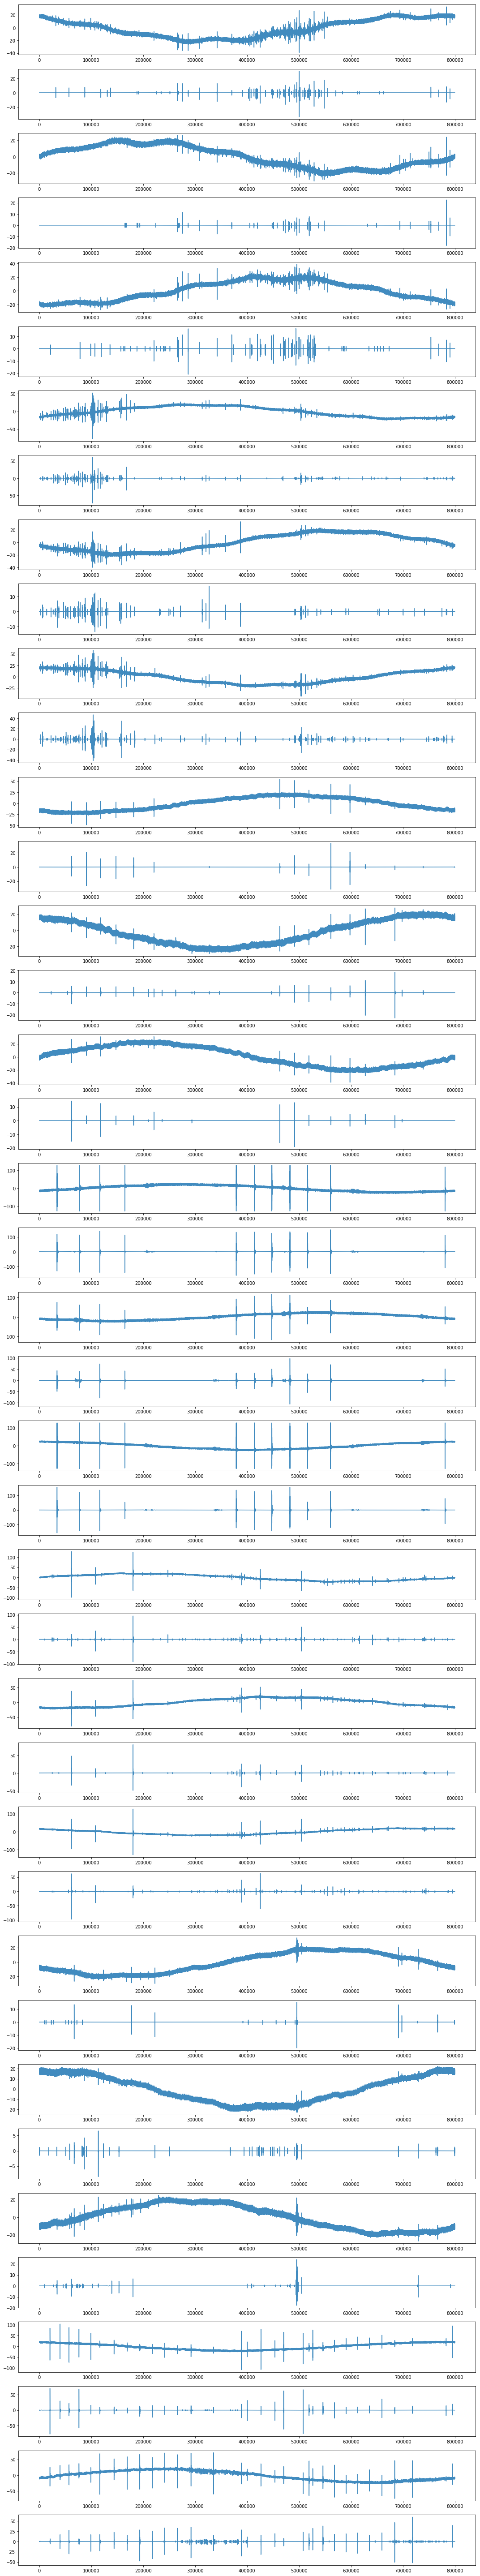

In [4]:
plt.close('all')
plt.cla()
plt.clf()

# plot params
num_signals = 18

f, axs = plt.subplots(num_signals * 2, 1, sharex=False, sharey=False, figsize=(15, num_signals * 4))

for i in np.arange(0,num_signals):
    j = 2*i
    sampling_freq = 1
    t = np.arange(0, raw_signals.shape[1]/sampling_freq)
    axs[j].plot(t, raw_signals[i,::sampling_freq], alpha=0.85)
    axs[j+1].plot(t, pp_signals[i,::sampling_freq], alpha=0.85)
    f.tight_layout()
plt.savefig('../visualizations/preprocess_demo_1.png')

**OK|NOK raw and preprocessed sample visualization**

<Figure size 432x288 with 0 Axes>

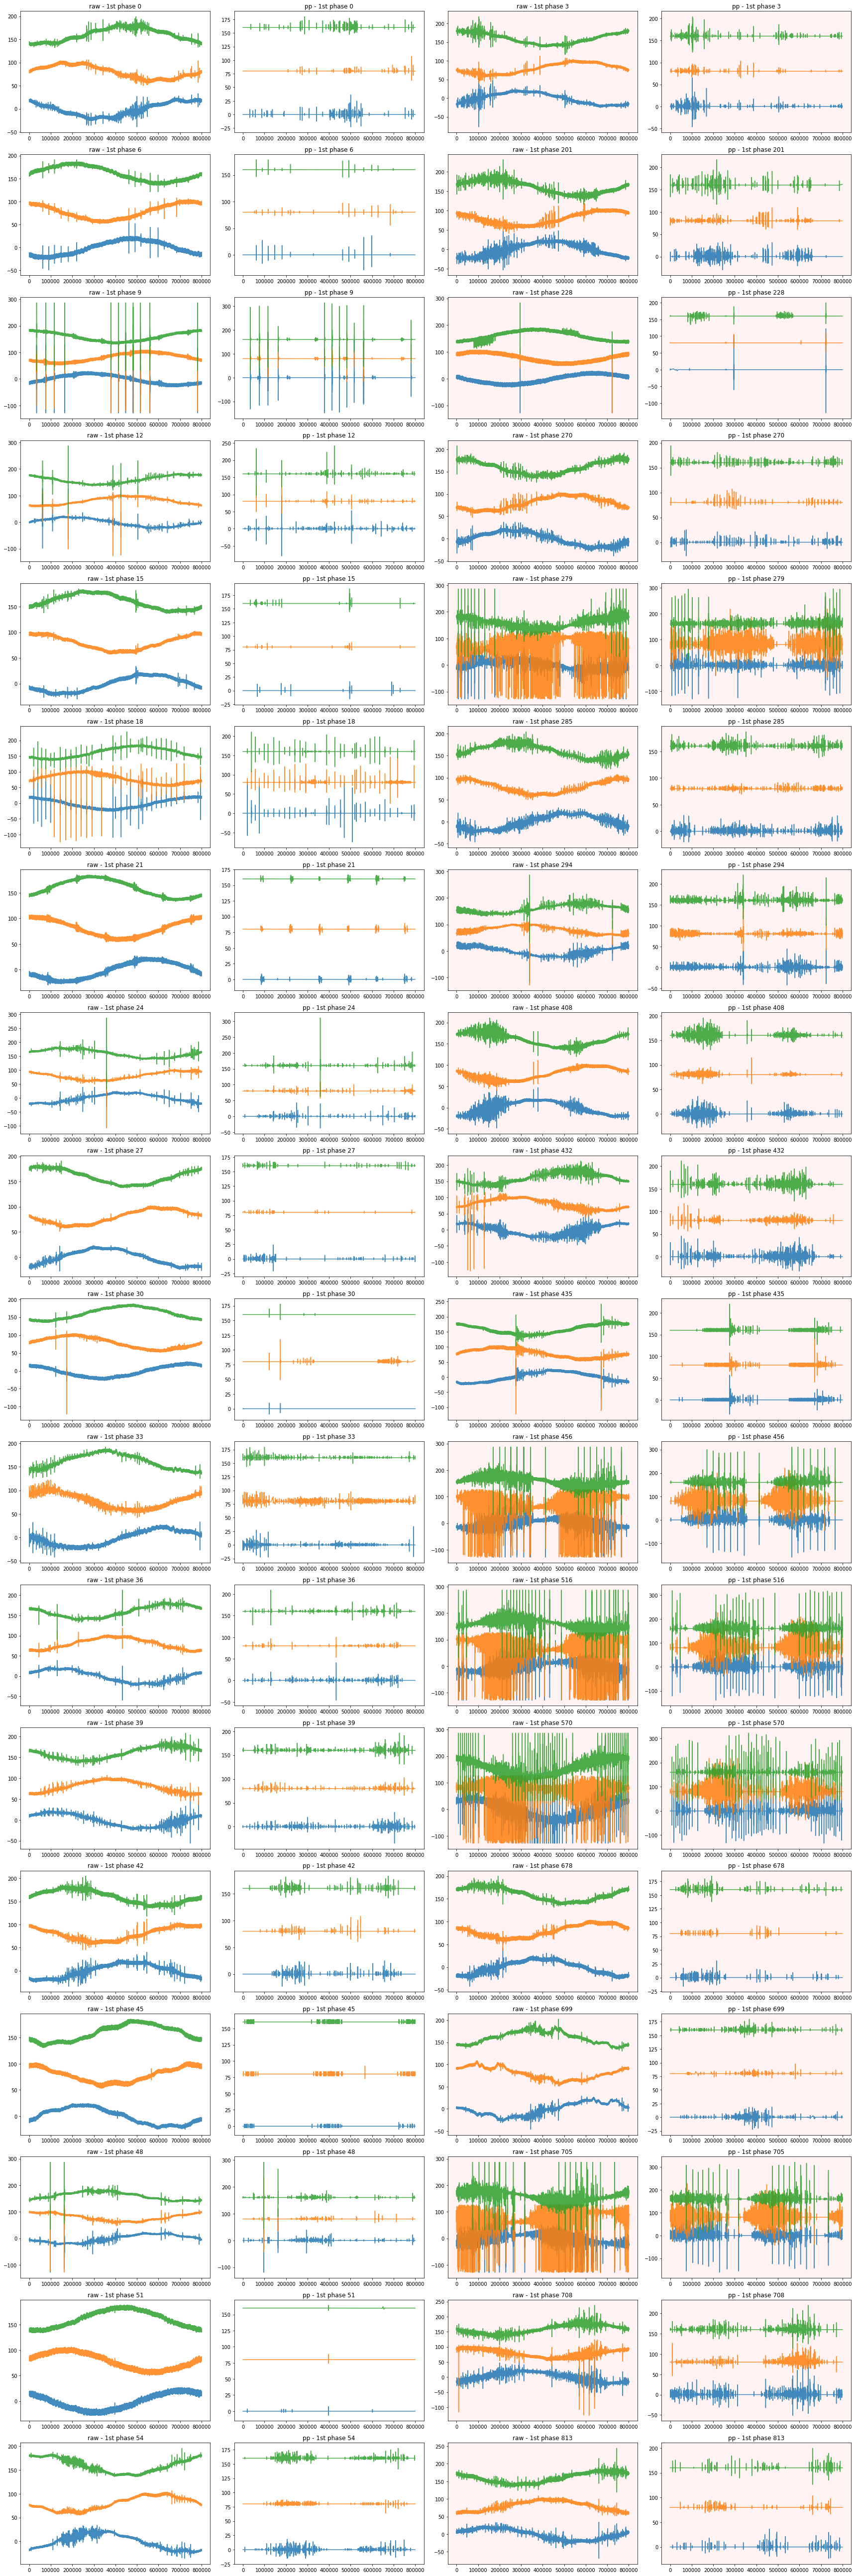

In [17]:
plt.close('all')
plt.cla()
plt.clf()

# plot params
num_signals = 18
samp_freq = 1

f, axs = plt.subplots(num_signals, 2 * 2, sharex=False, sharey=False, figsize=(2 * 2 * 6, num_signals * 4))

for k, (title, facecolor) in enumerate(zip(['OK', 'KO'], [(1, 1, 1), (1, 0.95, 0.95)])):

    # Grab first num_signals (either OK or KO depending on k) (might be grabbing partial OK/KO - ToDo)
    sig_ids = []
    for line in meta_train.values[::3,:]:
        if k == 0: # OK signals
            if line[-1] == 0:
                sig_ids.append(line[0])
                if len(sig_ids) == num_signals:
                    break # Done collecting
        else: # KO signals
            if line[-1] == 1:
                sig_ids.append(line[0])
                if len(sig_ids) == num_signals:
                    break # Done collecting
    
    for j, sig_type in enumerate(['raw', 'pp']):     
        t = np.arange(0, raw_signals.shape[1]/samp_freq)
        for i, sig_id in enumerate(sig_ids):
            axs[i,j + k*2].set_title(f'{sig_type} - 1st phase {sig_id:d}')
            for phase in [0,1,2]:
            
                if sig_type=='raw':
                    y = raw_signals[sig_id+phase, ::samp_freq] + phase * 80
                elif sig_type=='pp':
                    y = pp_signals[sig_id+phase, ::samp_freq] + phase * 80
                else:
                    raise ValueError('Unknown signal type')
                    
                axs[i,j + k*2].plot(t, y, alpha=0.85)
                axs[i,j + k*2].set_facecolor(facecolor)
                
    f.tight_layout()
plt.savefig('../visualizations/preprocess_ok_nok_db2.png')